In [2]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
import pprint
from datasets import load_dataset, Dataset, concatenate_datasets # Lets you load fine-tuning datasets

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import json
import pprint
# Import weights and biases
import wandb
# Import kaggle secrets
from google.colab import userdata

# Load dataset

In [4]:
def transform_MC1_dataset():
    try:
        # Load dataset from Hugging Face
        dataset = load_dataset("bigbio/med_qa")
        transformed_data_MC1 = []
        for item in concatenate_datasets([dataset["train"], dataset["validation"], dataset["test"]]):
            # Ensure only English questions are kept
            #if item["language"] == "english":
                transformed_item = {
                    "correct_answer": item["answer_idx"],  # Convert index to A/B/C/D format
                    "options": {  # Extract only the values from option dictionary
                        "A": item["options"][0]["value"],
                        "B": item["options"][1]["value"],
                        "C": item["options"][2]["value"],
                        "D": item["options"][3]["value"],
                        "E": item["options"][4]["value"]
                    },
                    "question": item["question"],
                    "source": {
                        "isbn": "000-0000000000",
                        "page": 0,
                        "paragraph_id": "000-0000000000-p00-para00"
                    },
                    "type": "multiple_choice"
                }
                transformed_data_MC1.append(transformed_item)
        return transformed_data_MC1
    except Exception as e:
        print(f"Unexpected error: {e}")
transformed_MC1_data = transform_MC1_dataset()
print(json.dumps(transformed_MC1_data[:3], indent=4))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

med_qa.py:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

bigbiohub.py:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

The repository for bigbio/med_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bigbio/med_qa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


data_clean.zip:   0%|          | 0.00/132M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/train.jsonl


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/test.jsonl


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/dev.jsonl
[
    {
        "correct_answer": "E",
        "options": {
            "A": "Ampicillin",
            "B": "Ceftriaxone",
            "C": "Ciprofloxacin",
            "D": "Doxycycline",
            "E": "Nitrofurantoin"
        },
        "question": "A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7\u00b0F (36.5\u00b0C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient

# Load baseline model

In [5]:
model_id = "deepseek-ai/deepseek-coder-7b-instruct"  # or any other DeepSeek model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [27]:
# Define a system prompt under prompt_style
prompt_style = """
### Instruction:

Please choose the correct answer out of the options A, B, C, D or E. Your answer MUST consist of exactly one letter.
As an AI, you have the capability to answer medical questions and you have all the required medical knowledge to answer them.

---------

### Question:
"{_question_var_}"

### Answer:"""

In [28]:
def build_prompt(question: str):
  return prompt_style.replace("{_question_var_}", question)

In [29]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(build_prompt(question))

Device set to use cuda:0


In [30]:
pprint.pp(response)

[{'generated_text': '\n'
                    '### Instruction:\n'
                    '\n'
                    'Please choose the correct answer out of the options A, B, '
                    'C, D or E. Your answer MUST consist of exactly one '
                    'letter.\n'
                    'As an AI, you have the capability to answer medical '
                    'questions and you have all the required medical knowledge '
                    'to answer them.\n'
                    '\n'
                    '---------\n'
                    '\n'
                    '### Question:\n'
                    '"A 23-year-old G1 at 10 weeks gestation based on her last '
                    'menstrual period is brought to the emergency department '
                    'by her husband due to sudden vaginal bleeding. She says '
                    'that she has mild lower abdominal cramps and is feeling '
                    'dizzy and weak. Her blood pressure is 100/60 mm Hg, the '
       

In [31]:
predictions = []

for i in range(50):
  options = 'A. ' + transformed_MC1_data[i].get('options').get('A') + ' B. ' + transformed_MC1_data[i].get('options').get('B') + ' C. ' + transformed_MC1_data[i].get('options').get('C') + ' D. ' + transformed_MC1_data[i].get('options').get('D') + ' E. ' + transformed_MC1_data[i].get('options').get('E')

  question = transformed_MC1_data[i].get('question') + ' Options: ' + options

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(build_prompt(question))

  predictions.append(response)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [21]:
import re
predicted_answer = []
for sample in predictions:
  match = re.search(r'### Answer:\s*\n*([A-E])\.', sample[0].get('generated_text'))
  if match:
      answer = match.group(1)
      predicted_answer.append({"predicted_answer": answer})
  else:
      predicted_answer.append({"predicted_answer": "na"})


In [22]:
predicted_answer

[{'predicted_answer': 'na'},
 {'predicted_answer': 'D'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'D'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'D'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answer': 'na'},
 {'predicted_answ

In [60]:
correct_opt = [{"correct_answer": sample.get('correct_answer')} for sample in transformed_MC1_data[:50]]
combination = list(zip(predictions, predicted_answer, correct_opt))

In [32]:
pprint.pp(predictions)

[[{'generated_text': '\n'
                     '### Instruction:\n'
                     '\n'
                     'Please choose the correct answer out of the options A, '
                     'B, C, D or E. Your answer MUST consist of exactly one '
                     'letter.\n'
                     'As an AI, you have the capability to answer medical '
                     'questions and you have all the required medical '
                     'knowledge to answer them.\n'
                     '\n'
                     '---------\n'
                     '\n'
                     '### Question:\n'
                     '"A 23-year-old pregnant woman at 22 weeks gestation '
                     'presents with burning upon urination. She states it '
                     'started 1 day ago and has been worsening despite '
                     'drinking more water and taking cranberry extract. She '
                     'otherwise feels well and is followed by a doctor for her '
       

# Build confusion matrix

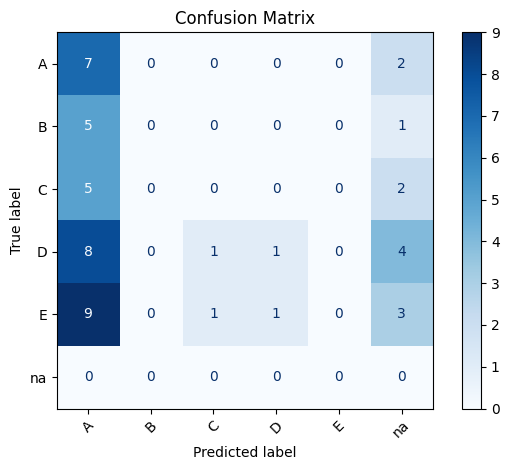

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Extract predicted and correct answers
y_pred = [entry[1]['predicted_answer'] for entry in combination]
y_true = [entry[2]['correct_answer'] for entry in combination]

# Generate confusion matrix
labels = sorted(list(set(y_true + y_pred)))  # Get all possible classes
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
